In [1]:
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [2]:
#load dataframe from csv
demographics_data = pd.read_csv("data/newdata/2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
demographics_data = demographics_data.drop(columns=["Geo_ZCTA5", "Geo_ZCTA3", "Geo_LOGRECNO", "Geo_GEOCOMP", "Geo_SUMLEV"])

(33120, 2151)


In [3]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


In [4]:
# drop any column with missing values greater than 5%
demographics_data.drop(columns=["SE_A18007_006","SE_A18007_007","SE_A18007_005","SE_A18007_004",
                     "SE_A18007_003","SE_A18007_002","SE_A18008_011",
                     "SE_A18008_010","SE_A18008_009","SE_A18010_002",
                     "SE_A18010_003","SE_A18010_004","SE_A18010_005",
                     "SE_A18010_006","SE_A18010_007","SE_A18008_001","SE_A18008_002",
                     "SE_A18008_003","SE_A18008_008","SE_A18008_007","SE_A18008_006","SE_A18008_005",
                     "SE_A18008_004"], axis=1, inplace=True)

In [47]:
reduced_demos = demographics_data[["SE_A00002_002", "SE_A14028_001", "SE_A14011_001", "SE_A14008_001", "SE_B10040_002", "SE_B10040_003"]]

In [352]:
null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
# reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
reduced_demos = MinMaxScaler().fit_transform(reduced_demos)

Series([], dtype: int64)
(30450, 6)


What does MinMaxScaler Scaler do to our data?

In [353]:
print(reduced_demos[0:5])

[[0.00000000e+00 5.96827262e-01 1.33404604e-02 5.31552611e-03
  1.15684897e-01 3.71390621e-01]
 [1.00676546e-05 5.72855464e-01 2.60706254e-02 6.47371025e-03
  8.56184512e-02 1.98953996e-01]
 [2.01353093e-05 6.47121034e-01 3.27100321e-02 4.66711518e-03
  1.08074472e-01 3.53363194e-01]
 [5.03382732e-05 5.47473561e-01 9.28144512e-03 6.62659364e-03
  1.38496648e-01 1.96948845e-01]
 [9.06088918e-05 5.32314924e-01 3.06754736e-02 7.07829024e-03
  8.03188582e-02 1.76877240e-01]]


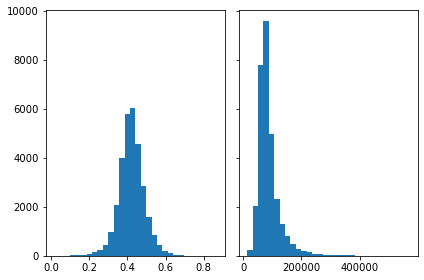

In [351]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

n_bins = 30

# We can set the number of bins with the `bins` kwarg
axs[0].hist(reduced_demos["SE_A14028_001"], bins=n_bins)
axs[1].hist(reduced_demos["SE_A14011_001"], bins=n_bins)
plt.show()

How does our best DBSCAN approach look?

Ok, maybe all along we've been picking bad datapoints to look at, lets just Gini index, Average household income, and rent as a percentage of income.

C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

SE_A14028_001           948
SE_A14011_001          1662
vacancy_rate            490
income_to_homevalue    2670
renters_pct             490
dtype: int64
(30450, 6)
 clusters:  155  and noise points  2913 , noise as :  0.09566502463054187


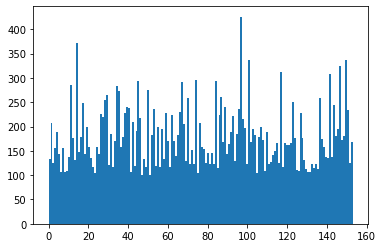

In [257]:

# just gini index and average household income
reduced_demos = demographics_data[["zip", "SE_A14028_001", "SE_A14011_001"]]
reduced_demos["vacancy_rate"] = demographics_data["SE_A10001_001"].divide(demographics_data["SE_A10044_002"])
reduced_demos["income_to_homevalue"] = demographics_data["SE_A10036_001"].divide(demographics_data["SE_A14011_001"])
reduced_demos["renters_pct"] = demographics_data["SE_A10060_003"].divide(demographics_data["SE_A10001_001"])

null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
#reduced_demos = StandardScaler().fit_transform(reduced_demos)

reduced_demos_no_zip = reduced_demos.drop("zip", axis=1)

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=3, cluster_selection_method='leaf')
clusterer.fit(reduced_demos_no_zip)

labels = clusterer.labels_
unique_labels = set(labels)
print( " clusters: ", len(unique_labels), " and noise points ", (labels == -1).sum(), ", noise as : ", (labels == -1).sum()/len(labels))

label_sum = []

for k in unique_labels:
    label_sum.append((labels == k).sum())
    
non_noise = labels[labels != -1]

plt.hist(non_noise, bins=len(unique_labels)-1)
plt.show()

In [258]:
clusters = reduced_demos[['zip']]
clusters["cluster"] = labels
clusters.head()

C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,zip,cluster
0,601,-1
1,602,-1
2,603,10
3,606,-1
4,610,-1


So using just those statistics we can get some pretty reasonable clusters. Now let's join those up with the sales data.

In [259]:
sales_data = pd.read_csv("data/newdata/med_sale_price_yoy.csv", delimiter="	")
sales_data.index = sales_data.index.astype(int)
sales_data = sales_data.rename(columns={"Region":"zip"})
sales_data = sales_data.fillna(0)
print(sales_data.head())

    zip February 2016 March 2016 April 2016 May 2016 June 2016 July 2016  \
0   501             0          0          0        0         0         0   
1  1005         15.4%       5.7%     -29.7%   -24.0%     33.7%      8.6%   
2  1010             0          0          0        0         0         0   
3  1031        705.0%     612.0%     -24.6%   -24.6%    -83.2%    -13.7%   
4  1037             0          0     -23.9%        0    102.7%    150.4%   

  August 2016 September 2016 October 2016  ... December 2019 January 2020  \
0           0              0            0  ...             0            0   
1        5.7%          -9.1%        -4.1%  ...          7.3%        -4.3%   
2           0              0            0  ...             0            0   
3       -3.3%          -2.0%        27.6%  ...         43.9%       -13.8%   
4      150.4%              0            0  ...             0            0   

  February 2020 March 2020 April 2020 May 2020 June 2020 July 2020  \
0         

In [260]:
Jan2020_sales = sales_data[['zip','January 2020']]
Jan2020_sales = Jan2020_sales.merge(clusters, on="zip")
Jan2020_sales["January 2020"] = Jan2020_sales["January 2020"].str.replace(r'%', r'')
Jan2020_sales = Jan2020_sales.fillna(0)
Jan2020_sales.head()

,zip,January 2020,cluster
0,1005,-4.3,33
1,1010,0,29
2,1031,-13.8,68
3,1037,0,17
4,1057,0,29


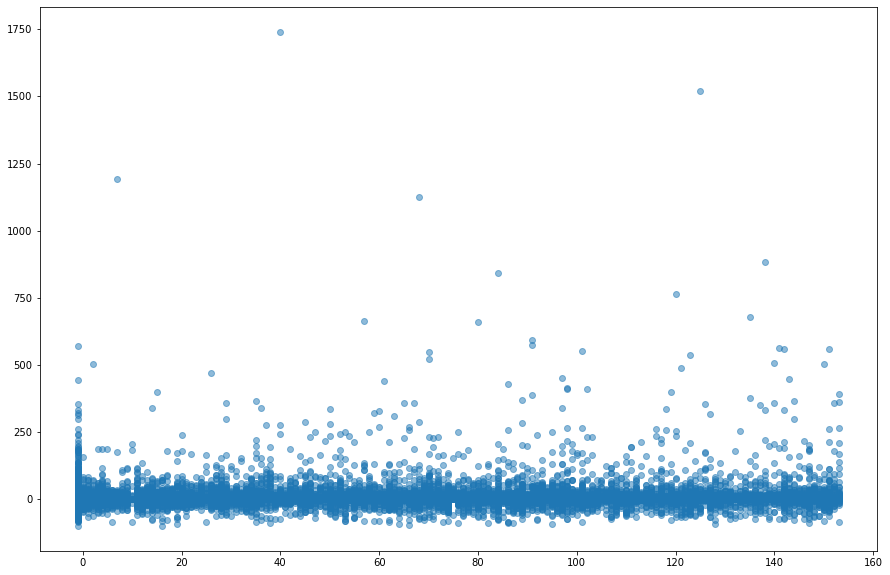

In [261]:
#colors = np.random.rand(N)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter( Jan2020_sales["cluster"].astype(int), Jan2020_sales["January 2020"].astype(float), alpha=0.5)

Let's get the standard deviation of each cluster and see what happens

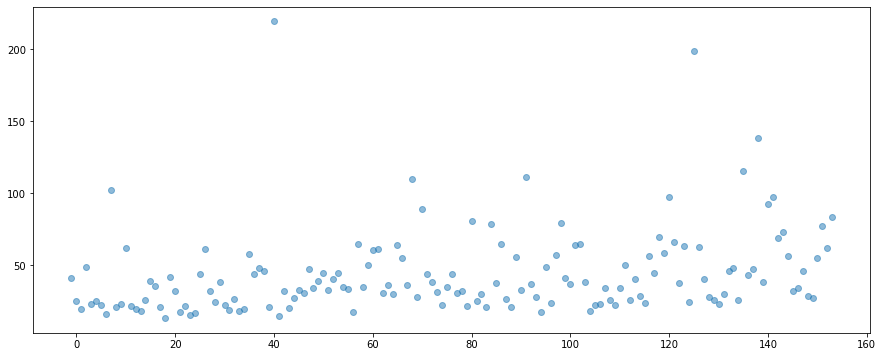

In [262]:

med_yoy_by_cluster = []

for cluster in np.unique(Jan2020_sales["cluster"]):
    sub = Jan2020_sales[Jan2020_sales.cluster == cluster]
    med_yoy_by_cluster.append(sub["January 2020"].astype(float).std())


fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter( np.unique(Jan2020_sales["cluster"]), med_yoy_by_cluster, alpha=0.5)

## Now to the regression part:


First off, we'll make our joined data

In [263]:
#join the sales data (has less zip codes, so right join)
joined_sales_data = clusters.set_index('zip').join(sales_data.set_index('zip'), how ='right')

# we still get NaN clusters, so let's drop those
joined_sales_data = joined_sales_data.dropna()
joined_sales_data = joined_sales_data.replace(np.nan,0)
print(joined_sales_data.shape)
joined_sales_data.head()


(14616, 57)


,cluster,February 2016,March 2016,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,...,December 2019,January 2020,February 2020,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020
zip,,,,,,,,,,,,,,,,,,,,,
1005,33.0,15.4%,5.7%,-29.7%,-24.0%,33.7%,8.6%,5.7%,-9.1%,-4.1%,...,7.3%,-4.3%,6.3%,-7.9%,2.2%,-4.4%,12.4%,-1.3%,4.5%,1.3%
1010,29.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1031,68.0,705.0%,612.0%,-24.6%,-24.6%,-83.2%,-13.7%,-3.3%,-2.0%,27.6%,...,43.9%,-13.8%,70.9%,162.0%,126.9%,-1.0%,-37.8%,-48.3%,-51.1%,681.4%
1037,17.0,0,0,-23.9%,0,102.7%,150.4%,150.4%,0,0,...,0,0,0,0,0,0,0,0,-24.4%,-14.5%
1057,29.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Now let's get a training and a test set so we can evaluate what's happening. I think we can put most of our data in the 

In [269]:
# get 5% of the rows to save for testing
joined_sales_data_test = joined_sales_data.sample(frac=0.05) 

# get 95% of the rows for training
joined_sales_data_train = joined_sales_data.drop(joined_sales_data_test.index) 


In [301]:
print(joined_sales_data_test.head())

       cluster February 2016 March 2016 April 2016 May 2016 June 2016  \
zip                                                                     
89178     36.0          4.9%       9.9%       9.3%    12.6%     11.8%   
37221     21.0         13.2%      12.7%      10.4%     8.8%      4.7%   
15628     97.0             0          0          0        0         0   
33880    117.0         11.4%      25.2%      23.5%    45.3%     27.4%   
33444     -1.0          6.6%      -7.0%     -11.8%    13.2%     25.7%   

      July 2016 August 2016 September 2016 October 2016  ... December 2019  \
zip                                                      ...                 
89178     10.7%        9.6%           8.9%         5.7%  ...          3.6%   
37221      6.4%        5.0%           5.2%         4.0%  ...          6.2%   
15628         0           0              0            0  ...             0   
33880     23.2%       19.5%           6.7%        13.4%  ...          5.6%   
33444      9.8%     

In [328]:

from sklearn import linear_model

#copied from emily
def cluster_regression( regression_data, cluster_index ):
#     print('cluster_index ', cluster_index)
    clust0 = regression_data[regression_data['cluster']==cluster_index]
#     print(clust0.shape)
    clust0 = clust0.drop(columns=['cluster'])
    clust0_melt = pd.melt(clust0.reset_index(), id_vars=['zip'], value_vars=list(clust0.columns), var_name='date', value_name='yoy')
#     print(clust0_melt.shape)
    clust0 = clust0_melt.dropna()
    clust0.reset_index(drop=True, inplace=True)
    clust0['parsed_date'] = pd.to_datetime(clust0.loc[:,'date'], infer_datetime_format=True)
    clust0['days_from_start'] = clust0.loc[:,'parsed_date'] - clust0.loc[0, 'parsed_date']
    if('%' in str(clust0['yoy'].any())):
        clust0['yoy'] = clust0['yoy'].str.replace(r'%', r'')
        clust0['yoy'] = pd.to_numeric(clust0["yoy"], downcast="float")
    clust0 = clust0.replace(np.nan,0) #sometimes removing the '%' gets weird
#     print(clust0.shape)
#     print(clust0.head(-10))
    
    x = clust0['days_from_start'].values
    y = clust0['yoy'].values
    x = x.reshape(-1, 1)

    model = linear_model.LinearRegression().fit(x, y)
    return model

    # The coefficients
    #print('Coefficients: \n', model.coef_)
    
    
# not sure if this is possible :(
def cluster_regression_all_clusters( regression_data ):
    
    # is there a way to have our x be:
    for cl in np.unique(joined_sales_data["cluster"]):
        x = [clust0['days_from_start'].values, clust0['yoy'].values]
        y = cl

    

Now we make a Linear Regresion model for each cluster

In [329]:
clusters_and_models = []

for cl in np.unique(joined_sales_data_train["cluster"]):
    clusters_and_models.append([cl, cluster_regression(joined_sales_data_train, cl)])

Now some way of checking which of our generated linear models is closest to the linear model of another member of the clusters


In [330]:
# what do we know about the model?
which_model = 3
print(clusters_and_models[which_model][1].coef_, clusters_and_models[which_model][1].intercept_, clusters_and_models[which_model][1].singular_)

[-2.20984459e-17] 7.740011290676983 [3.41027737e+18]


In [337]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

cluster_labels_train = []
cluster_models_train = []

for cm in clusters_and_models:
    cluster_labels_train.append(cm[0])
    cluster_models_train.append([cm[1].coef_, cm[1].intercept_, cm[1].singular_])

gaussNB = GaussianNB(var_smoothing=0.5)
gaussNB.fit(cluster_models_train, cluster_labels_train)

C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


GaussianNB(var_smoothing=0.5)

Now we can see what happens with our testing data

In [339]:
test_clusters_and_models = []

for cl in np.unique(joined_sales_data_test["cluster"]):
    test_clusters_and_models.append([cl, cluster_regression(joined_sales_data_test, cl)])
    

cluster_labels_test = []
cluster_models_test = []

for cm in clusters_and_models:
    cluster_labels_test.append(cm[0])
    cluster_models_test.append([cm[1].coef_, cm[1].intercept_, cm[1].singular_])


In [350]:
from sklearn.metrics import classification_report

print(gaussNB.score(cluster_models_test, cluster_labels_test))
preds = gaussNB.predict(cluster_models_test)

labels_str = []
for l in np.unique(cluster_labels_test):
    labels_str.append(str(l))

print(classification_report(cluster_labels_test, preds, target_names=labels_str))

#Create Confusion Matrix
confMatrix = confusion_matrix(cluster_labels_test, preds, labels=np.unique(cluster_labels_test))
print(confMatrix)

0.5741935483870968
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00         1
         0.0       0.50      1.00      0.67         1
         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00         1
         3.0       0.50      1.00      0.67         1
         4.0       1.00      1.00      1.00         1
         5.0       0.00      0.00      0.00         1
         6.0       1.00      1.00      1.00         1
         7.0       0.50      1.00      0.67         1
         8.0       0.25      1.00      0.40         1
         9.0       0.50      1.00      0.67         1
        10.0       1.00      1.00      1.00         1
        11.0       1.00      1.00      1.00         1
        12.0       1.00      1.00      1.00         1
        13.0       0.50      1.00      0.67         1
        14.0       1.00      1.00      1.00         1
        15.0       0.33      1.00      0.50         1
        

C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted